# Data analysis

## Libraries

In [5]:
library(tidyverse)
library(ggplot2)
library(expint)
library(rvalues)
library(mosaic)
library(pracma)
library(dplyr)
library(igraph)

# First plot

### Reading the data

In [508]:
df <- read.csv('ERG_simulation_data.csv')

In [509]:
head(df)

,nodes,max.update,n.seeds,threshold,z,time,n.run,cascade.fraction
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>
1,10000,100,1,0.1,1,8,10,0.0021
2,10000,100,1,0.1,1,2,10,0.0001
3,10000,100,1,0.1,1,2,10,0.0001
4,10000,100,1,0.1,1,2,10,0.0001
5,10000,100,1,0.1,1,16,10,0.0028
6,10000,100,1,0.1,1,6,10,0.0007


### Processing of the data

In [510]:
data <- df %>% group_by(threshold, z)%>% arrange(desc(cascade.fraction), .by_group=TRUE) %>% filter(row_number()==1)

### Dividing cascade and not

In [511]:
cascade <- data %>% filter(cascade.fraction>=0.1)
no_cascade <- data %>% filter(cascade.fraction <0.1)

### Plot of the data

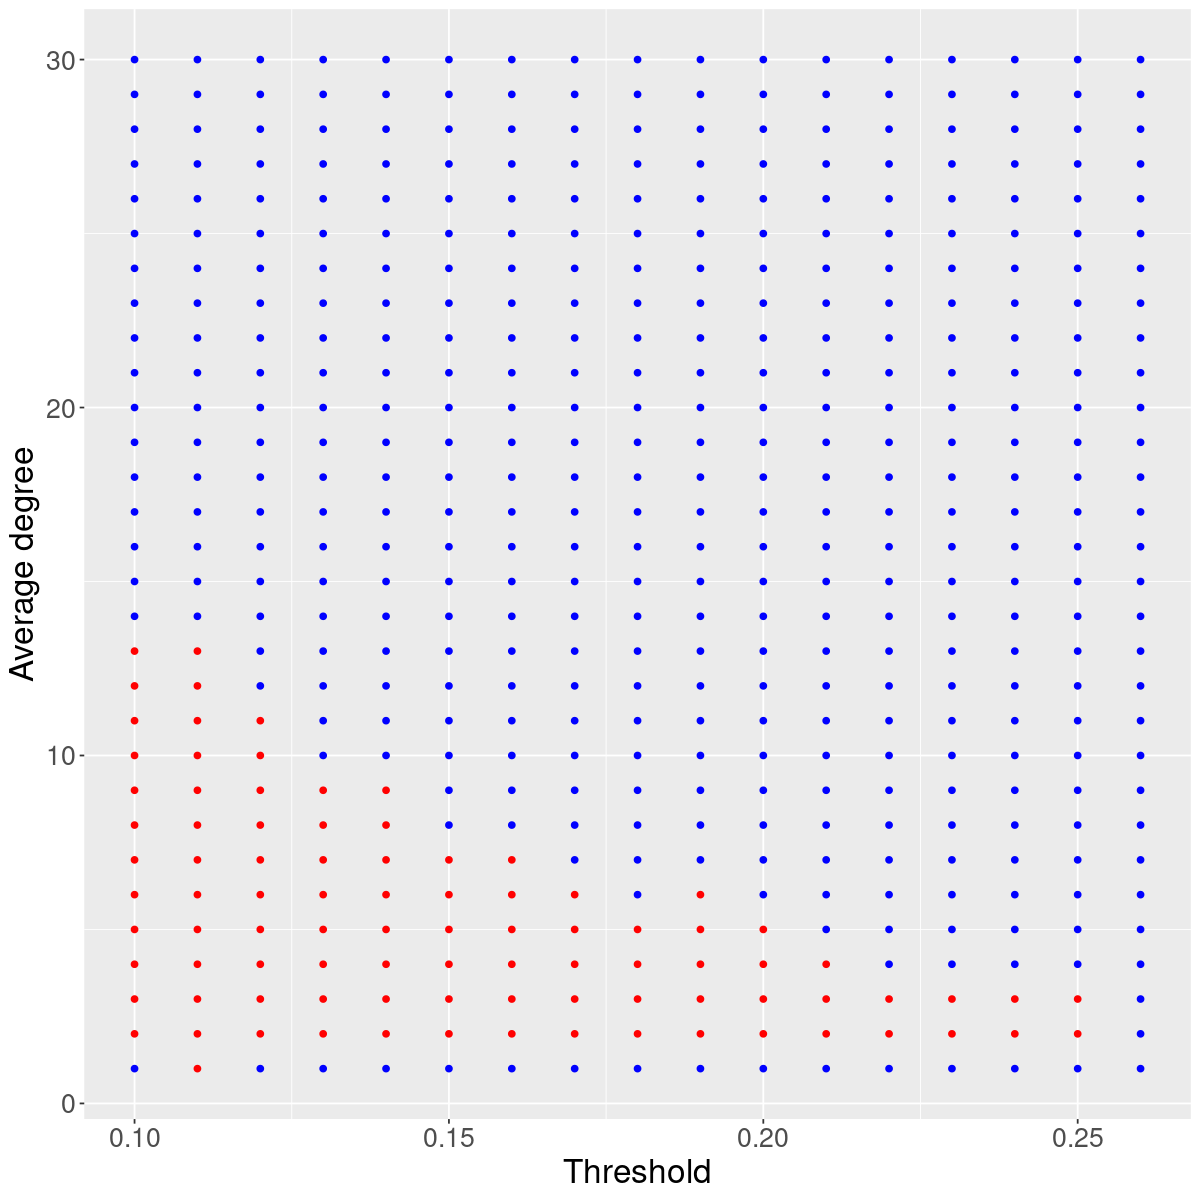

In [512]:
ggplot() +
    geom_point(data = cascade, aes(x=threshold,y=z, colour='Empirical cascade'), col='red')+
    geom_point(data = no_cascade, aes(x=threshold,y=z, colour='No empirical cascade'), col='blue')+
    xlab(label = 'Threshold')+
    ylab(label = 'Average degree')+
    theme(text = element_text(size = 20)) 

### Theoretical prediction

### Grid approach

In [270]:
#grid for theoretical prediction
phi <- seq(from = 0.1, to = 0.26, by=0.001)
z <- seq(from=1, to=16, by=0.1)
var <- expand.grid(z, phi)

In [290]:
gammainc(var[1,1], floor(1/var[1, 2])-1)['lowinc'][[1]]

[1] 0.04536817

In [293]:
fun <- vector()
for (i in 1:nrow(var)){
    #print(gammainc(var[i,1], floor(1/var[i, 2])-1))
    fun[i]<-var[i,1]*gammainc(var[1,1], floor(1/var[1, 2])-1)['lowinc'][[1]]-1 
}


In [294]:
prediction <- data.frame(var[,1], var[,2], fun)
colnames(prediction) <- c('z', 'phi', 'fun')

In [295]:
theoretical_cascade <- prediction |> filter(abs(fun)>1)

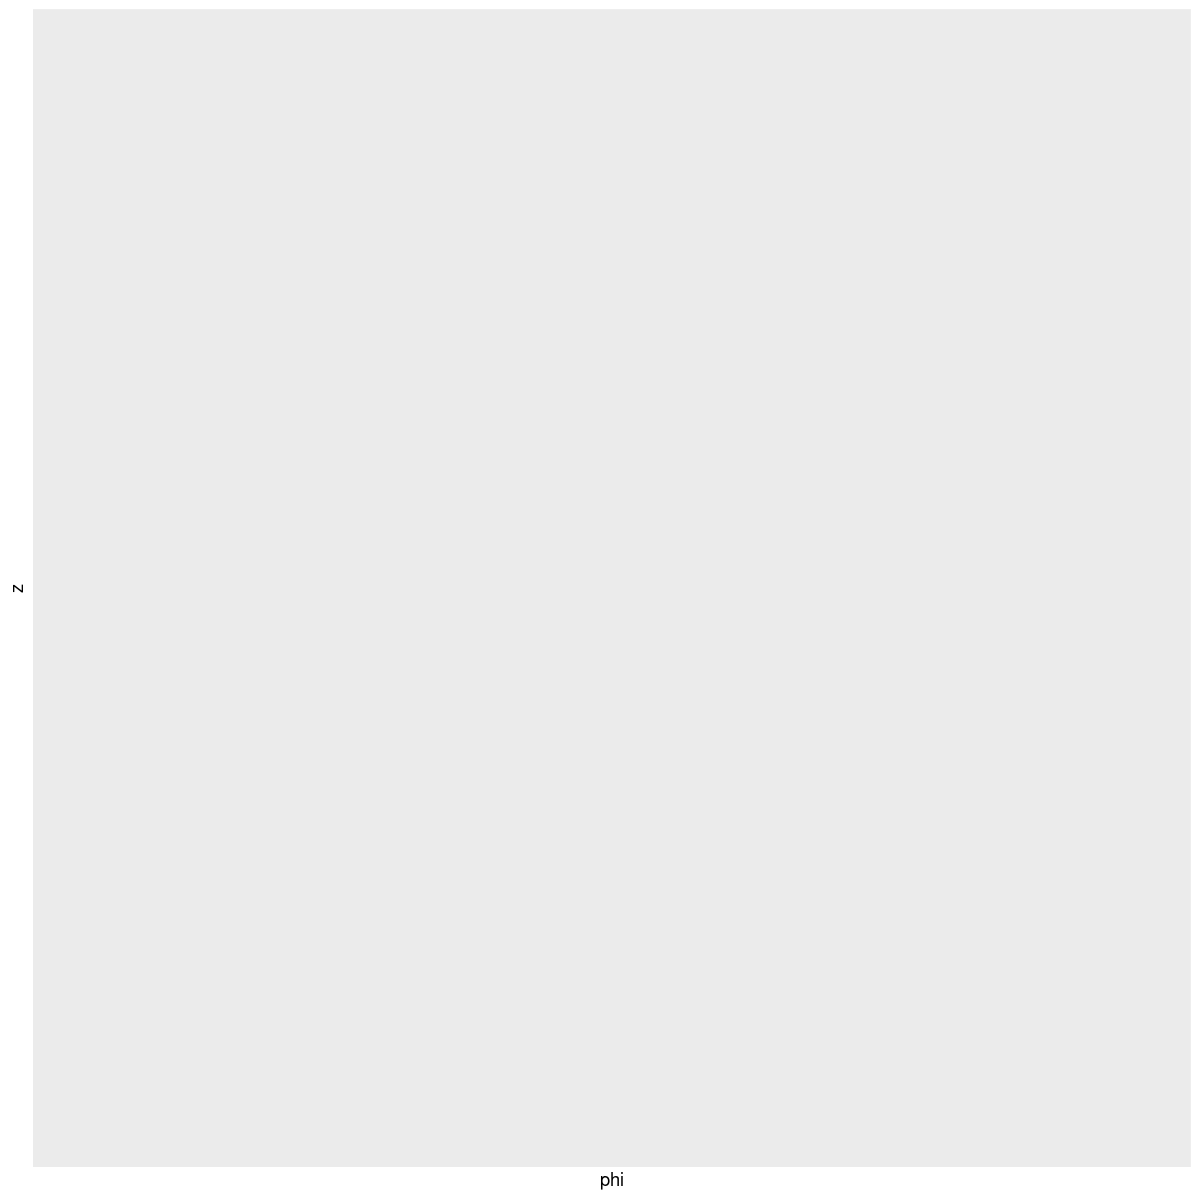

In [296]:
#plot of theoretical predicition
ggplot() +
    geom_point(data = theoretical_cascade, aes(x=phi, y=z, colour='Theoretical cascade area'), col='khaki1')

### Solution of cascade condition

In [513]:
gamma_inc <- function(a, x, type='upper'){
    out <- 0
    if(type=='upper'){
        out <- integrate(integranda, a=a, x, Inf)
    }
    else if(type=='lower'){
        out <- integrate(integranda, a=a, 0, x)
    }
    return(out$value)
}

In [514]:
integranda <- function(t, a){
    return(t^(a-1)*exp(-t))
}

In [515]:
phi.list <- seq(from = 0.1, to = 0.25, by=0.001)

In [516]:
condition <- function(z, phi, type='upper'){
    out <- 0
    if(type=='upper'){
        out <- z*gamma_inc(floor(1/phi)-1, z, 'upper')-1
    }
    else if(type=='lower'){
        out <- z*gamma_inc(floor(1/phi)-1, z, 'lower')-1
    }
    return(out)
}

In [517]:
lower_z=1
upper_z=40
n_intervals=1000

In [518]:
z.roots.upper <- c()
phi.roots.upper <- c()
for(phi in phi.list){

    h <- (upper_z-lower_z)/n_intervals
    #print(h)
    segments <- seq(from= lower_z, to=upper_z, by=h)

    for (i in 1:(n_intervals-1)){
        if(condition(segments[i], phi, 'upper')*condition(segments[i+1], phi, 'upper')<0){
            #print(segments[i], segments[i+1])
            zero <- uniroot(condition, phi=phi, type='upper', lower=segments[i], upper=segments[i+1])$root
            z.roots.upper <- c(z.roots.upper, zero)
            phi.roots.upper <- c(phi.roots.upper, phi)
        }
    }
}

In [519]:
z.roots.lower <- c()
phi.roots.lower <- c()
for(phi in phi.list){

    h <- (upper_z-lower_z)/n_intervals
    #print(h)
    segments <- seq(from= lower_z, to=upper_z, by=h)

    for (i in 1:(n_intervals-1)){
        if(condition(segments[i], phi, 'lower')*condition(segments[i+1], phi, 'lower')<0){
            #print(segments[i], segments[i+1])
            zero <- uniroot(condition, phi=phi, type='lower', lower=segments[i], upper=segments[i+1])$root
            z.roots.lower <- c(z.roots.lower, zero)
            phi.roots.lower <- c(phi.roots.lower, phi)
        }
    }
}

In [520]:
teor.lower <- data.frame(phi.roots.lower, z.roots.lower)
teor.upper <- data.frame(phi.roots.upper, z.roots.upper)

In [521]:
#plot(phi.roots.lower, z.roots.lower)
#plot(phi.roots.upper, z.roots.upper)

### Comparison between theoretical prediction and data

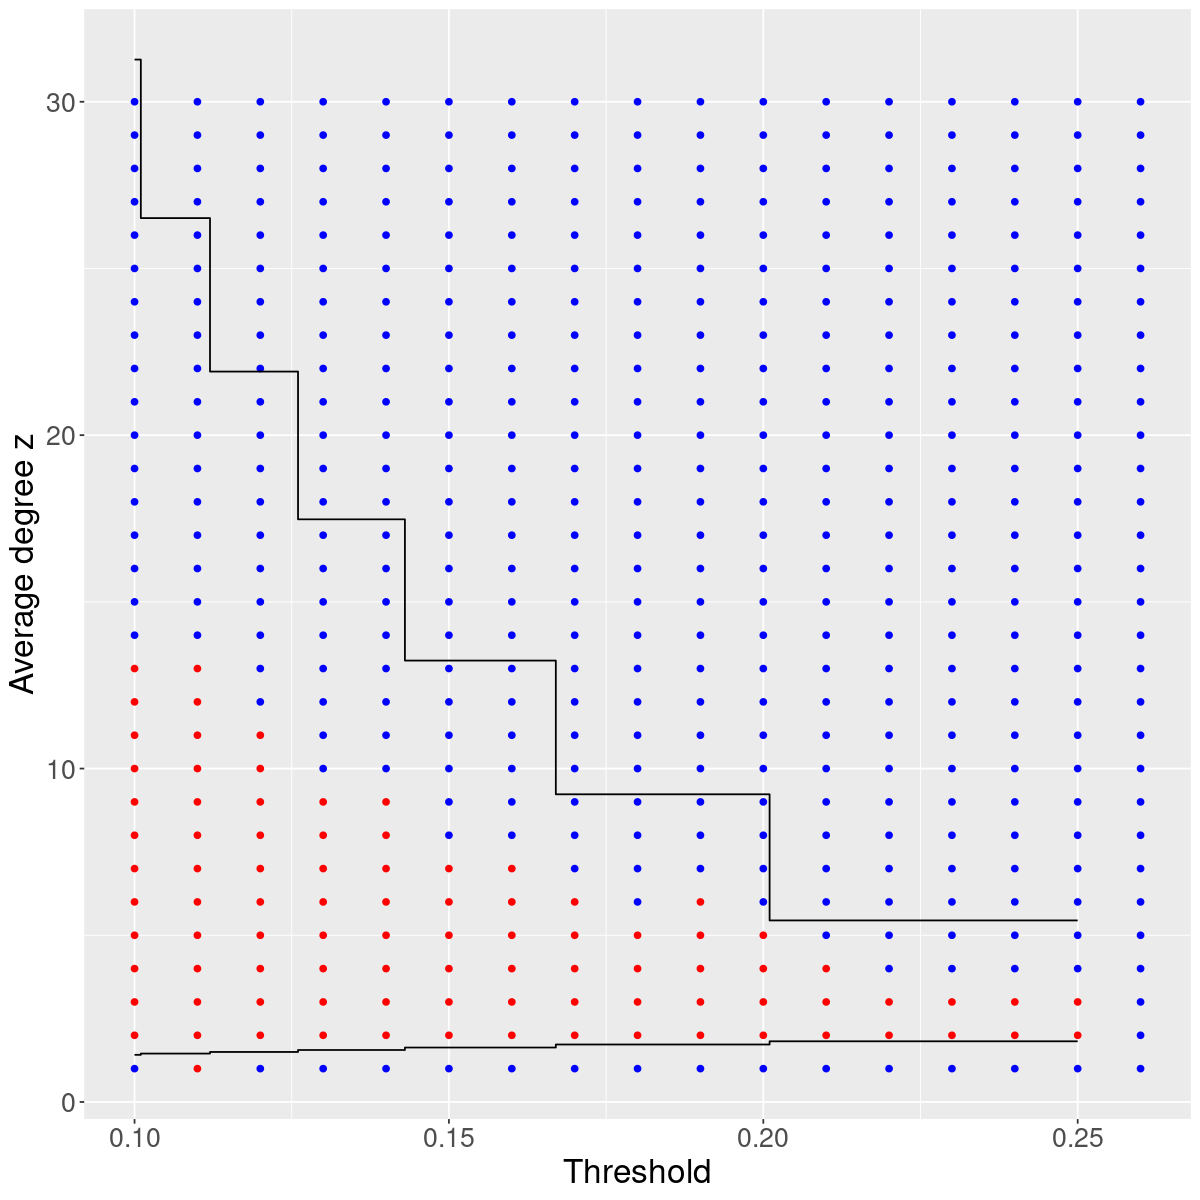

In [522]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot() +
    geom_point(data = cascade, aes(x=threshold,y=z, colour='Empirical cascade'), col='red')+
    geom_point(data = no_cascade, aes(x=threshold,y=z, colour='No empirical cascade'), col='blue')+
    geom_step(data=teor.lower, aes(x=phi.roots.lower, y=z.roots.lower), col='black')+
    geom_step(data=teor.upper, aes(x=phi.roots.upper, y=z.roots.upper), col='black')+
    xlab(label = 'Threshold')+
    ylab(label = 'Average degree z')+
    theme(text = element_text(size = 20)) 


# Second plot

In [65]:
df <- read.csv('ERG_simulation_plot2.csv')

In [66]:
head(df)

,nodes,max.update,n.seeds,threshold,z,time,n.run,cascade.fraction
,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,10000,100,1,0.18,0.5,3,10,2e-04
2,10000,100,1,0.18,0.5,3,10,2e-04
3,10000,100,1,0.18,0.5,2,10,1e-04
4,10000,100,1,0.18,0.5,2,10,1e-04
5,10000,100,1,0.18,0.5,2,10,1e-04
6,10000,100,1,0.18,0.5,3,10,3e-04


In [67]:
times <- df %>% group_by(z) %>% summarize(mean_time=mean(time)-2)

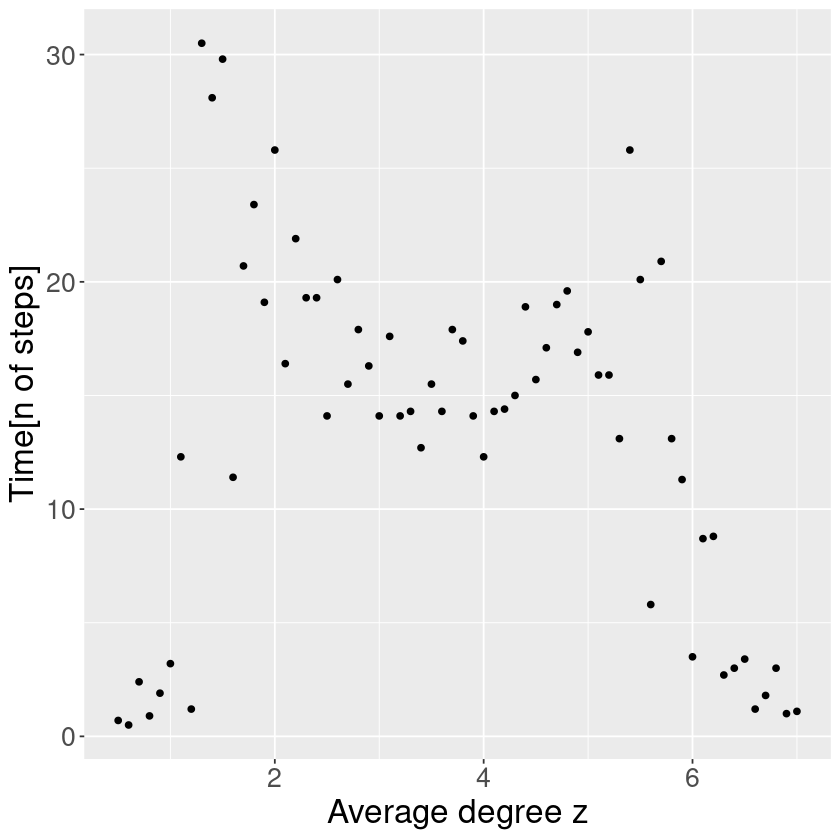

In [68]:
ggplot()+
    geom_point(data=times, aes(x=z, y=mean_time))+
      xlab(label = 'Average degree z')+
    ylab(label = 'Time[n of steps]')+
    theme(text = element_text(size = 20)) 


## Prediction of connected component

In [69]:
#selecting only the simulations with cascade failures
df.cascade <- df %>% filter(cascade.fraction>0.1)

In [70]:
connected_component <- function(S, z){
    return(S-1+exp(-z*S))
}

In [71]:
z <- seq(1.1, 7, by=0.1)
lower <- rep(0.1, length(z))
upper <- rep(1, length(z))

In [72]:
S <- c()
for (i in seq_along(z)){
    root <- uniroot(connected_component, z=z[i], lower=lower[i], upper=upper[i])$root
    S <- c(S, root )
    }

In [73]:
prediction <- data.frame(z, S)

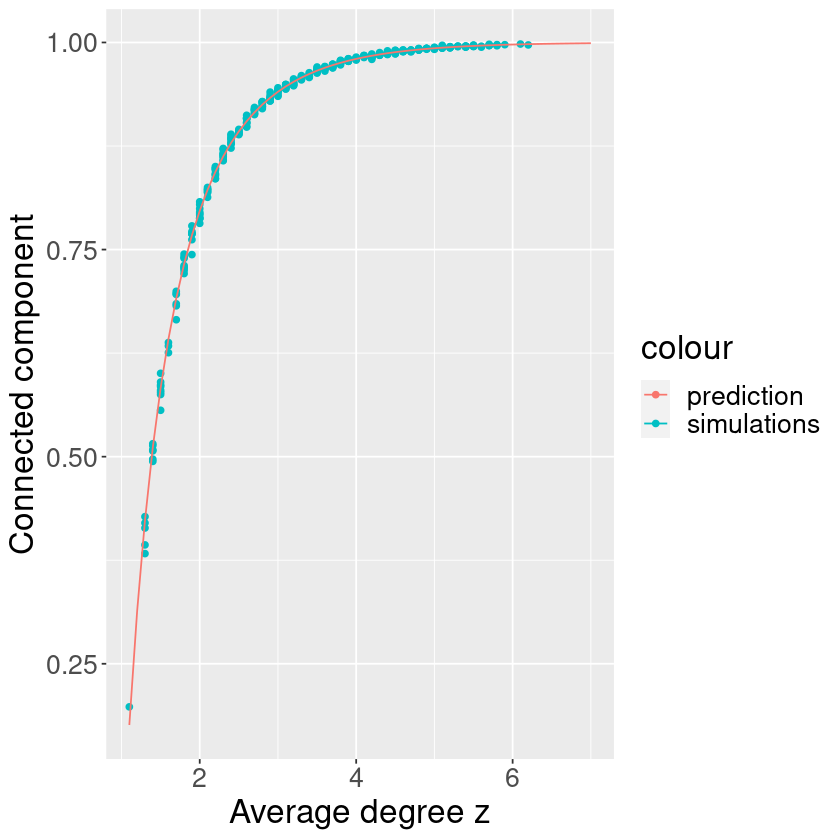

In [74]:
ggplot()+
    geom_point(data=df.cascade, aes(x=z, y=cascade.fraction, col='simulations'))+
    geom_line(data=prediction, aes(x=z, y=S, col='prediction'))+
    xlab(label = 'Average degree z')+
    ylab(label = 'Connected component')+
    theme(text = element_text(size = 20)) 

# Prediction of probability of cascade

In [75]:
n.run <-10

In [76]:
count_prob <- df %>% group_by(z) %>% filter(cascade.fraction>0.1) %>% summarize(prob = n())
count_prob['prob']<- count_prob['prob']/n.run

In [77]:
z.values <- unique(df['z'])

In [78]:
prob <- merge(x = z.values, y = count_prob, by = 'z', all.x = TRUE) %>% mutate_all(~replace(., is.na(.), 0))

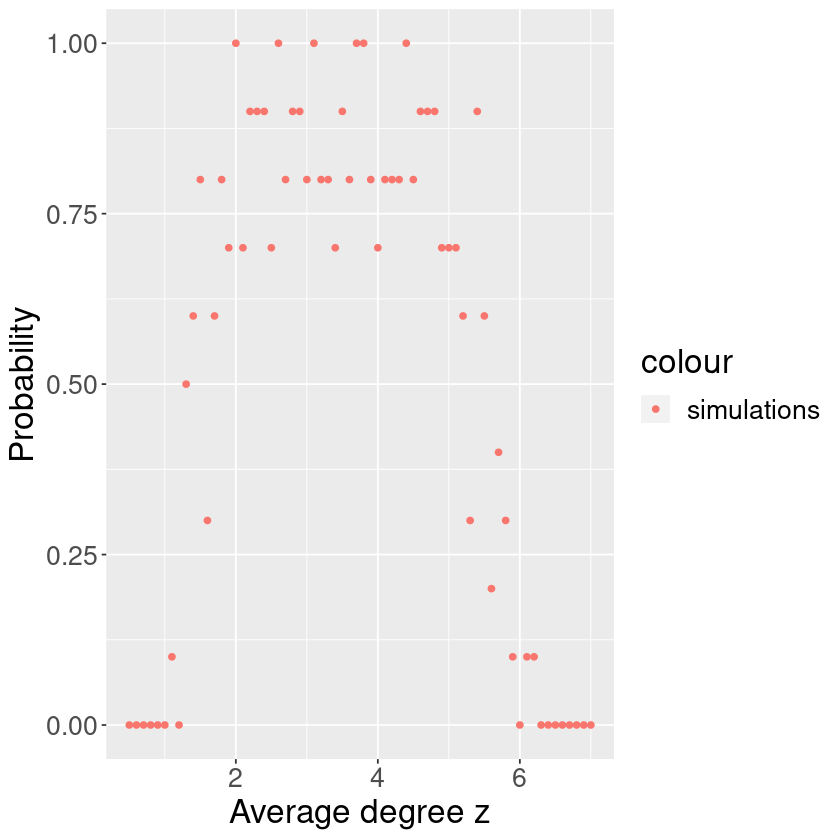

In [79]:
ggplot()+
    geom_point(data=prob, aes(x=z, y=prob, col='simulations'))+
    #geom_line(data=prediction, aes(x=z, y=S, col='prediction'))+
    xlab(label = 'Average degree z')+
    ylab(label = 'Probability')+
    theme(text = element_text(size = 20)) 

## Approximated prediction of vulnerable nodes

In [116]:
z.list <- seq(from=0.5, to=7, by=0.1)
n <- 10000 #number of nodes
phi=0.18
n.run <- 1
filename <- 'probability_prediction2.csv'

In [113]:
Sv.list <-c()
Se.list <-c()

write.table(list('n', 'z', 'phi', 'n.run', 'Sv', 'Se'),
           file = filename,
           append = TRUE,
           sep = ',', 
           row.names = FALSE,
           col.names = FALSE)

for(z in z.list){
    Sv <- 0
    Se <- 0
    for(i in 1:n.run){
        #Realization of a network
        p=z/n

        g <- erdos.renyi.game(n = n,
            p.or.m = p,  
            type = "gnp",
            directed = FALSE,
            loops = FALSE)

        nodes.neighbors <- list()

        for (i in 1:n){
            nodes.neighbors[i] <- list(neighbors(g, i))
        }

        nodes.vulnerable <- c()
        for (j in seq_along(nodes.neighbors)){
            if(length(nodes.neighbors[[j]])<1/phi){
                nodes.vulnerable <- c(nodes.vulnerable, j)
            }
        }
        
        if(length(nodes.vulnerable)!=0){
            gv<-subgraph(g, nodes.vulnerable)
#print(clusters(gv, mode="strong"))
    
            components <- clusters(gv, mode="strong")
            max_size_gv <- max(components$csize)
            biggest_cluster_id <- which.max(components$csize)
            vert_ids <- V(gv)[components$membership == biggest_cluster_id]

        }else {
            max_size_gv <- 0
        }

        Sv <- Sv+ max_size_gv/n

        
        vert <- vector()
        for (i in 1:length(vert_ids)){
            vert[i]<- vert_ids[i]
        }
      

        nodes.ex.vulnerable <- vert
        
        for (k in seq_along(nodes.neighbors[vert])){
            nodes.ex.vulnerable <- c(nodes.ex.vulnerable,nodes.neighbors[nodes.vulnerable][[k]] )
        }
        nodes.ex.vulnerable<- unique(nodes.ex.vulnerable)
        
        if(length(nodes.ex.vulnerable)!=0){
            ge<-subgraph(g, nodes.ex.vulnerable)
        #print(clusters(gv, mode="strong"))

            size_components_ge <-clusters(ge, mode="strong")$csize
        #print(size_components_gv)
            max_size_ge <- max(size_components_ge)

        }else {
            max_size_ge <- 0
        }

        Se <-Se+ max_size_ge/n
        
     
    }
    Se.list<- c(Se.list, Se/n.run)
    Sv.list<- c(Sv.list, Sv/n.run)
    write.table(list(n, z, phi, n.run, Sv/n.run, Se/n.run),
            file = filename,
            append = TRUE,
            sep = ',', 
            row.names = FALSE,
            col.names = FALSE)
}

In [117]:
prob_pred <- read.csv('probability_prediction2.csv')

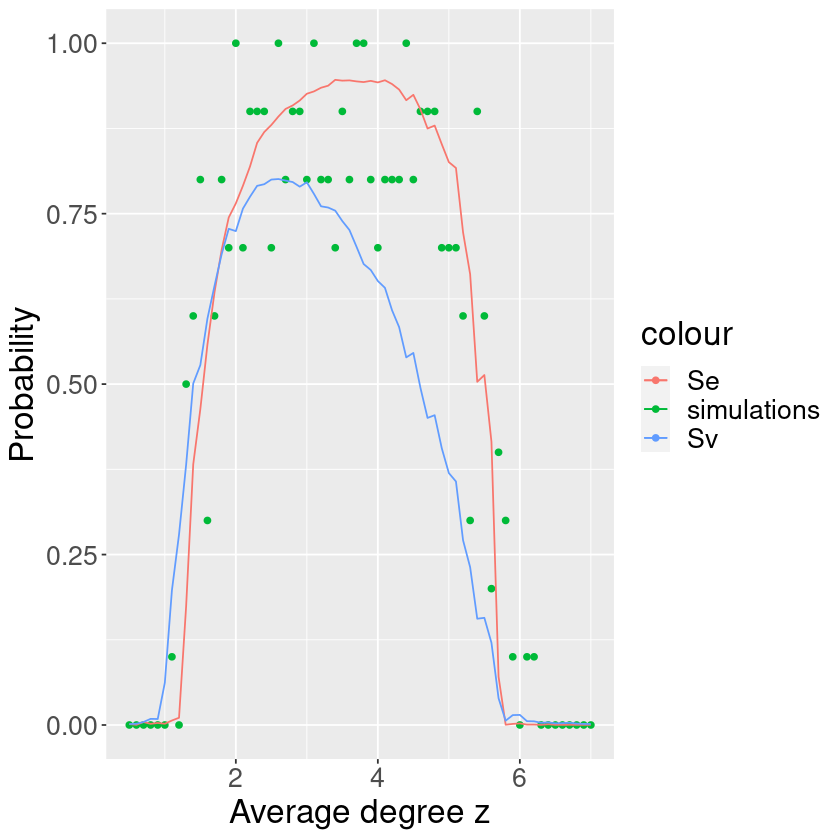

In [119]:
ggplot()+
    geom_point(data=prob, aes(x=z, y=prob, col='simulations'))+
    geom_line(data=prob_pred, aes(x=z, y=Se, col='Se'))+
    geom_line(data=prob_pred, aes(x=z, y=Sv, col='Sv'))+
    xlab(label = 'Average degree z')+
    ylab(label = 'Probability')+
    theme(text = element_text(size = 20)) 